# Job Search with Separation

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

We study a job search model with separation using NumPy and Numba.

## Model Setup

- Jobs terminate with probability α each period (separation rate)
- An unemployed agent receives a wage offer sequence $(w_t)$ until accepting a
  new job
- Wage offers follow a Markov chain with transition matrix $P$
- Employed agents maintain a constant wage during their employment
- An agent who separates from a job with wage $w$ draws a new offer from
  distribution $P(w, \cdot)$
- Unemployed workers receive compensation $c$ each period
- Future payoffs discounted by factor $\beta \in (0,1)$

## Decision Problem

When unemployed and receiving wage offer $w$, the agent chooses between:

1. Accept offer $w$ and work at this wage until separation
2. Reject offer: Remain unemployed, receive $c$, get new offer next period

## Value Functions

Let 

- $v_u(w)$ be the value of being unemployed when current wage offer is $w$
- $v_e(w)$ be the value of being employed at wage $w$

## Bellman Equations

The unemployed worker's value function satisfies:

$$v_u(w) = \max\{v_e(w), c + \beta \sum_{w'} v_u(w') P(w,w')\}$$

The employed worker's value function satisfies:

$$v_e(w) = w + \beta[\alpha \sum_{w'} v_u(w') P(w,w') + (1-\alpha) v_e(w)]$$

We can rewrite these using matrix-vector style notation as

$$v_u = \max\{v_e, c + \beta P v_u \}$$

The employed worker's value function satisfies:

$$v_e = \vec w + \beta[\alpha P v_u + (1-\alpha) v_e]$$

Here $\vec w$ is a vector containing the list of possible wage offers.

## Computational Approach

1. Solve the employed value function in terms of $v_u$:

   $$v_e(w) = \frac{1}{1-\beta(1-\alpha)} \cdot (w + \alpha\beta(Pv_u)(w))$$

3. Substitute into unemployed Bellman equation to get:

   $$v_u(w) = \max\left\{\frac{1}{1-\beta(1-\alpha)} \cdot (w + \alpha\beta(Pv_u)(w)), c + \beta(Pv_u)(w)\right\}$$

4. Use value function iteration to solve for  the fixed point $v_u^*$
5. Compute optimal policy: accept if $v_e^*(w) ≥ c + \beta(Pv_u^*)(w)$

The optimal policy is a reservation wage strategy: accept all wages above
some threshold $\bar w$.

## Code

In addition to what's in Anaconda, this lecture will need the QE library:

In [1]:
#!pip install quantecon  # Uncomment if necessary

We use the following imports:

In [2]:
from quantecon.markov import tauchen
import numpy as np
from typing import NamedTuple, Callable, Union
import matplotlib.pyplot as plt
import numba

First, we implement the successive approximation algorithm:

In [3]:
def successive_approx(
        T: Callable,               # Operator
        x_0: np.ndarray,           # Initial condition
        tolerance: float = 1e-6,   # Error tolerance
        max_iter: int = 100_000,   # Max iteration bound
        verbose: bool = False
    ):
    """
    Computes the approximate fixed point of T via successive
    approximation.

    """
    x = x_0
    error = tolerance + 1
    k = 1
    while (error > tolerance) and (k <= max_iter):
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        x = x_new
        k += 1
    if error <= tolerance:
        if verbose:
            print(f"Terminated successfully in {k} iterations.")
    else:
        print("Warning: hit iteration bound.")
    return x

Let's set up a `Model` class to store information needed to solve the model:

In [4]:
class Model(NamedTuple):
    n: int
    w_vals: np.ndarray
    P: np.ndarray
    β: float
    c: float
    α: float

The function below holds default values and creates a `Model` instance:

In [5]:
def create_js_with_sep_model(
        n: int = 200,          # wage grid size
        ρ: float = 0.9,        # wage persistence
        ν: float = 0.2,        # wage volatility
        β: float = 0.96,       # discount factor
        α: float = 0.05,       # separation rate
        c: float = 1.0         # unemployment compensation
    ) -> Model:
    """Creates an instance of the job search model with separation."""
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return Model(n, w_vals, P, β, c, α)

Here's the Bellman operator for the unemployed worker's value function.

It implements the map

$$
    Tv_u = \max\left\{
    \frac{1}{1-\beta(1-\alpha)} \cdot (\vec w + \alpha\beta Pv_u), c + \beta Pv_u 
    \right\}
$$

In [6]:
@numba.jit
def T(v: np.ndarray, model: Model) -> np.ndarray:
    """The Bellman operator for the value of being unemployed."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * P @ v)
    reject = c + β * P @ v
    return np.maximum(accept, reject)

The next function computes the optimal policy under the assumption that v is
the value function:

In [7]:
@numba.jit
def get_greedy(v: np.ndarray, model: Model) -> np.ndarray:
    """Get a v-greedy policy."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * P @ v)
    reject = c + β * P @ v
    σ = accept >= reject
    return σ

Here's a routine for value function iteration:

In [8]:
def vfi(model: Model, verbose: bool = False):
    """Solve by VFI."""
    v_init = np.zeros(model.w_vals.shape)
    v_star = successive_approx(lambda v: T(v, model), v_init, verbose)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

Here's a function to compute the reservation wage given a policy $\sigma$

In [9]:
def get_reservation_wage(σ: np.ndarray, model: Model) -> float:
    """
    Calculate the reservation wage from a given policy.

    Parameters:
    - σ: Policy array where σ[i] = True means accept wage w_vals[i]
    - model: Model instance containing wage values

    Returns:
    - Reservation wage (lowest wage for which policy indicates acceptance)
    """
    n, w_vals, P, β, c, α = model

    # Find all wage indices where policy indicates acceptance
    accept_indices = np.where(σ)[0]

    if len(accept_indices) == 0:
        return np.inf  # Agent never accepts any wage

    # Return the lowest wage that is accepted
    return w_vals[accept_indices[0]]

## Computing the Solution

Let's solve the model and plot the results:

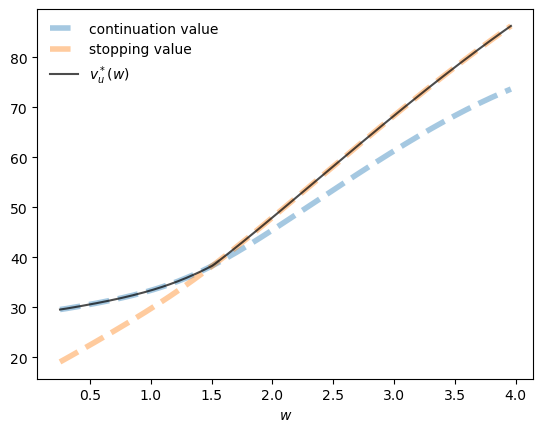

In [10]:
model = create_js_with_sep_model()
n, w_vals, P, β, c, α = model
v_star, σ_star = vfi(model)

d = 1 / (1 - β * (1 - α))
accept = d * (w_vals + α * β * P @ v_star)
h_star = c + β * P @ v_star

w_star = get_reservation_wage(σ_star, model)

fig, ax = plt.subplots()
ax.plot(w_vals, h_star, linewidth=4, ls="--", alpha=0.4,
        label="continuation value")
ax.plot(w_vals, accept, linewidth=4, ls="--", alpha=0.4,
        label="stopping value")
ax.plot(w_vals, v_star, "k-", alpha=0.7, label=r"$v_u^*(w)$")
ax.legend(frameon=False)
ax.set_xlabel(r"$w$")
plt.show()

## Exercise

Examine how reservation wages change with the separation rate α.  

Interpret your results.  Start with

In [11]:
α_vals: np.ndarray = np.linspace(0.0, 1.0, 10)

In [12]:
# Put your code here

In [13]:
for _ in range(20):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


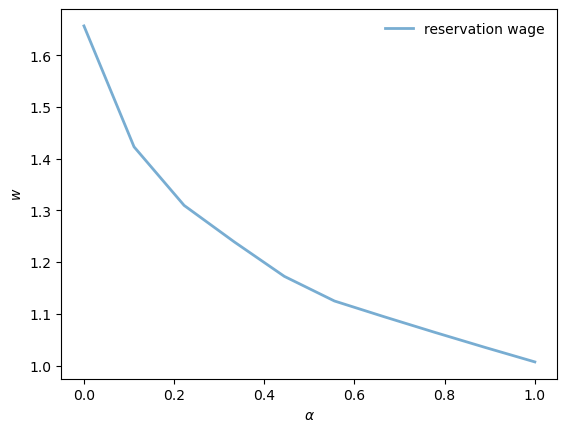

In [14]:
w_star_vec = np.empty_like(α_vals)

for i_α, α in enumerate(α_vals):
    model = create_js_with_sep_model(α=α)
    v_star, σ_star = vfi(model)
    w_star = get_reservation_wage(σ_star, model)
    w_star_vec[i_α] = w_star

fig, ax = plt.subplots()
ax.plot(
    α_vals, w_star_vec, linewidth=2, alpha=0.6, label="reservation wage"
)
ax.legend(frameon=False)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$w$")
plt.show()

## Employment Simulation

Now let's simulate the employment dynamics of a single agent under the optimal policy:

In [15]:
@numba.jit
def weighted_choice(probs):
    """Numba-compatible weighted random choice."""
    cumsum = np.cumsum(probs)
    return np.searchsorted(cumsum, np.random.random())

@numba.jit
def update_agent(is_employed, wage_idx, model, σ_star):

    n, w_vals, P, β, c, α = model

    if is_employed: # Employed update
        # Separation => become unemployed and draw new wage
        if np.random.random() < α:
            is_employed = False
            wage_idx = weighted_choice(P[wage_idx, :])
        # No separation => employment status and wage unchanged
        else:
            pass

    else: # Unemployed update
        # Accept => become employed and hold wage unchanged
        if σ_star[wage_idx]:
            is_employed = True
        # Reject => stay unemployed and update wage
        else:
            wage_idx = weighted_choice(P[wage_idx, :])

    return is_employed, wage_idx

In [16]:
def simulate_employment_path(
        model: Model,     # Model detaisl
        T: int = 2_000,   # Simulation length
        seed: int = 42    # Set seed for simulation
    ):
    """
    Simulate employment path for T periods starting from unemployment.

    """
    np.random.seed(seed)
    # Unpack, solve for optimal policy
    n, w_vals, P, β, c, α = model
    v_star, σ_star = vfi(model)

    # A series wage_path to track the wage that the agent will use to
    # update their wage offer (constant when employed)
    wage_path = np.zeros(T)
    # A series to track employment status (0 = unemployed, 1 = employed)
    employment_status = np.zeros(T, dtype=int)

    # Start unemployed with uniform wage draw
    is_employed = False
    wage_idx = 0

    for t in range(T):
        wage_path[t] = w_vals[wage_idx]
        employment_status[t] = is_employed
        is_employed, wage_idx = update_agent(
            is_employed, wage_idx, model, σ_star
        )

    return wage_path, employment_status

Let's create a comprehensive plot of the employment simulation:

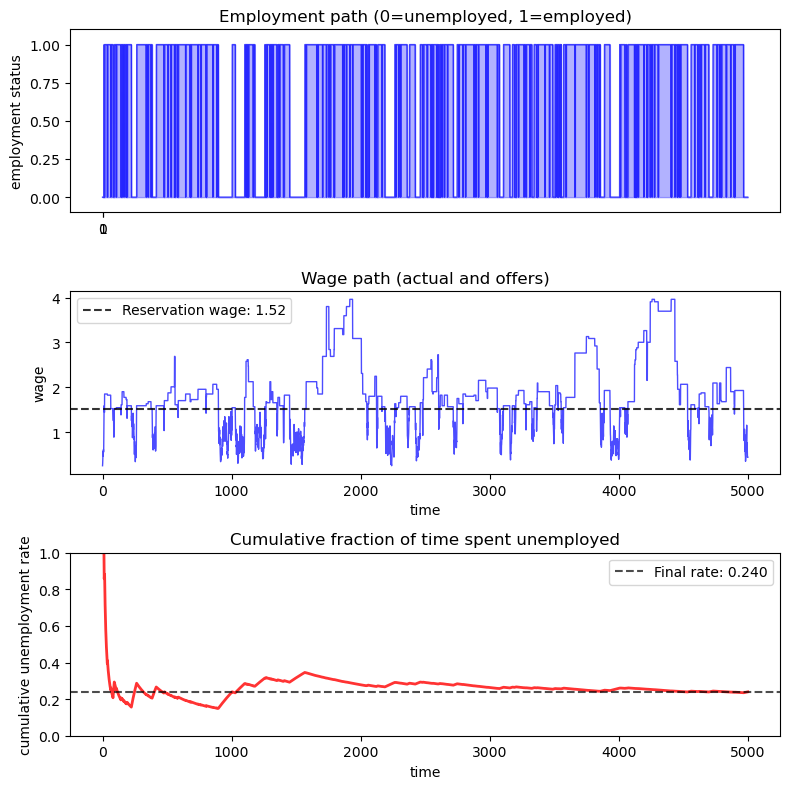

In [17]:
model = create_js_with_sep_model()

# Calculate reservation wage for plotting
v_star, σ_star = vfi(model)
w_star = get_reservation_wage(σ_star, model)

wage_path, employment_status = simulate_employment_path(model, T=5_000)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Plot employment status
ax1.plot(employment_status, 'b-', alpha=0.7, linewidth=1)
ax1.fill_between(
    range(len(employment_status)), employment_status, alpha=0.3, color='blue'
)
ax1.set_ylabel('employment status')
ax1.set_title('Employment path (0=unemployed, 1=employed)')
ax1.set_xticks((0, 1))
ax1.set_ylim(-0.1, 1.1)

# Plot wage path with employment status coloring
ax2.plot(wage_path, 'b-', alpha=0.7, linewidth=1)
ax2.axhline(y=w_star, color='black', linestyle='--', alpha=0.8,
           label=f'Reservation wage: {w_star:.2f}')
ax2.set_xlabel('time')
ax2.set_ylabel('wage')
ax2.set_title('Wage path (actual and offers)')
ax2.legend()

# Plot cumulative fraction of time unemployed
unemployed_indicator = (employment_status == 0)
cumulative_unemployment = (
    np.cumsum(unemployed_indicator) /
    np.arange(1, len(employment_status) + 1)
)

ax3.plot(cumulative_unemployment, 'r-', alpha=0.8, linewidth=2)
ax3.axhline(y=np.mean(unemployed_indicator), color='black',
            linestyle='--', alpha=0.7,
            label=f'Final rate: {np.mean(unemployed_indicator):.3f}')
ax3.set_xlabel('time')
ax3.set_ylabel('cumulative unemployment rate')
ax3.set_title('Cumulative fraction of time spent unemployed')
ax3.legend()
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary statistics

## Results Summary

The simulation demonstrates the model's key predictions:

1. **Optimal Policy**: The agent follows a reservation wage strategy
2. **Employment Dynamics**: Realistic patterns of job search, acceptance, and separation
3. **Steady State**: The cumulative unemployment rate converges to the theoretical prediction
4. **Labor Market Flows**: Clear cycles between unemployment and employment spells

The model successfully captures the essential features of labor market dynamics with job separation, showing how workers optimally balance the trade-off between accepting current offers versus waiting for better opportunities.

## Cross-Sectional Analysis

Now let's simulate many agents simultaneously to examine the cross-sectional unemployment rate:

In [18]:
@numba.jit
def simulate_cross_section_numba(
        employment_matrix, is_employed, wage_indices, model, σ_star,
        n_agents, T
    ):
    """Numba-accelerated simulation loop."""
    for t in range(T):
        for agent in range(n_agents):
            employment_matrix[agent, t] = 1 if is_employed[agent] else 0
            is_employed[agent], wage_indices[agent] = update_agent(
                is_employed[agent], wage_indices[agent], model, σ_star
            )

def simulate_cross_section(
        model: Model,
        n_agents: int = 100_000,
        T: int = 200,
        seed: int = 42
    ) -> tuple[np.ndarray, np.ndarray]:
    """
    Simulate employment paths for many agents simultaneously.

    Parameters:
    - model: Model instance with parameters
    - n_agents: Number of agents to simulate
    - T: Number of periods to simulate
    - seed: Random seed for reproducibility

    Returns:
    - unemployment_rates: Fraction of agents unemployed at each period
    - employment_matrix: n_agents x T matrix of employment status
    """
    np.random.seed(seed)

    # Solve for optimal policy
    v_star, σ_star = vfi(model)
    n, w_vals, P, β, c, α = model

    # Initialize arrays
    employment_matrix = np.zeros((n_agents, T), dtype=np.int32)
    wage_indices = np.random.randint(0, n, size=n_agents)
    is_employed = np.zeros(n_agents, dtype=np.bool_)

    # Run the accelerated simulation
    simulate_cross_section_numba(
        employment_matrix, is_employed, wage_indices, model, σ_star,
        n_agents, T
    )

    # Calculate unemployment rate at each period
    unemployment_rates = 1 - np.mean(employment_matrix, axis=0)

    return unemployment_rates, employment_matrix

def plot_cross_sectional_unemployment(model: Model):
    """
    Generate cross-sectional unemployment rate plot for a given model.

    Parameters:
    - model: Model instance with parameters
    """
    unemployment_rates, employment_matrix = simulate_cross_section(model)

    fig, ax = plt.subplots()

    # Plot unemployment rate over time
    ax.plot(unemployment_rates, 'b-', alpha=0.8, linewidth=1.5,
            label=f'Cross-sectional unemployment rate (c={model.c})')

    # Add shaded region for ±1 standard deviation
    window_size = 50
    rolling_std = np.array([
        np.std(unemployment_rates[max(0, t-window_size):t+1])
        for t in range(len(unemployment_rates))
    ])

    ax.fill_between(range(len(unemployment_rates)),
                    unemployment_rates - rolling_std,
                    unemployment_rates + rolling_std,
                    alpha=0.2, color='blue',
                    label='±1 rolling std')

    ax.set_xlabel('time')
    ax.set_ylabel('unemployment rate')
    ax.set_title(f'Cross-sectional unemployment rate (c={model.c})')
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

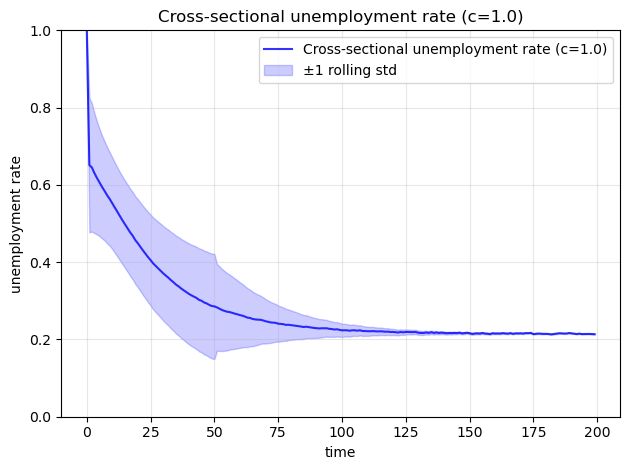

In [19]:
model = create_js_with_sep_model()
plot_cross_sectional_unemployment(model)



Let's examine how the cross-sectional unemployment rate changes with lower unemployment compensation:

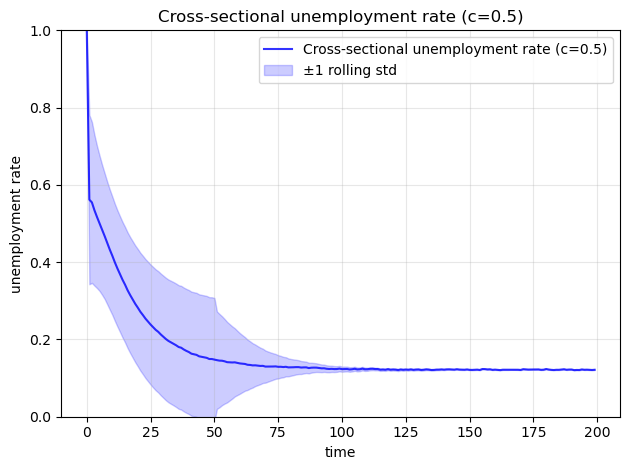

In [20]:
model_low_c = create_js_with_sep_model(c=0.5)
plot_cross_sectional_unemployment(model_low_c)

## Exercise

Create a plot that shows how the steady state cross-sectional unemployment rate
changes with unemployment compensation.

In [21]:
# put your code here

In [22]:
for _ in range(20):
    print('Solution below!')

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


## Solution

In [23]:
c_values = 1.0, 0.8, 0.6, 0.4, 0.2
rates = []
for c in c_values:
    model = create_js_with_sep_model(c=c)
    unemployment_rates, employment_matrix = simulate_cross_section(model)
    rates.append(unemployment_rates[-1])

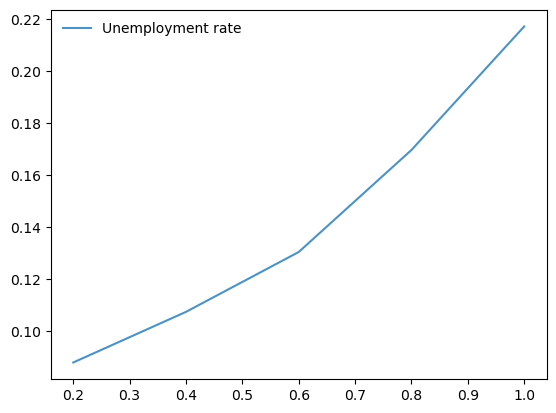

In [24]:
fig, ax = plt.subplots()
ax.plot(
    c_values, rates, alpha=0.8, 
    linewidth=1.5, label=f'Unemployment rate'
)
ax.legend(frameon=False)
plt.show()